# Skin segmentation

In this assignement you will train classifier to assign colors to skin or no skin classes. The data is taken from [Skin Segmentation Data Set](http://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) in the UCI Machine Learning repository.

The  data is in a plain text format and contains four columns. First three contain RGB color data  represented as integers in the range 0-255, and the last column is an integer label  with 1 representing skin and 2 representing no skin. This file we can load directly into a numpy array:

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [62]:
data = np.loadtxt('Skin_NonSkin.txt')

In [63]:
rgb  = data[:,:3].astype('float32')
lbl = data[:,3].astype('float32') 
lbl = 2-lbl

In [64]:
len(data)

245057

In [65]:
np.bincount(lbl.astype('int32'))

array([194198,  50859], dtype=int64)

## Problem 1

Train the neural network to distinguish skin from no skin colors. Calculate the accuracy on train and validation sets. Calculate true positives rate and false positives rate.

In [66]:
rgb_t = torch.from_numpy(rgb)
lbl_t = torch.from_numpy(lbl).reshape(-1,1)

In [67]:
dataset = torch.utils.data.TensorDataset(rgb_t, lbl_t)

In [68]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset,(200000,45057))

In [69]:
tb = np.bincount(train_dataset[:][1][:,0])

In [70]:
tb[1]/tb[0]

0.2629930409083446

In [71]:
vb = np.bincount(validation_dataset[:][1][:,0])

In [72]:
vb[1]/vb[0]

0.25703046534984936

In [73]:
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

In [74]:
model = nn.Sequential(nn.Linear(3,9), nn.ReLU(), nn.Linear(9,1))

In [75]:
loss_f = nn.BCEWithLogitsLoss()

In [76]:
opt = torch.optim.SGD(model.parameters(), lr=0.01)

In [77]:
decreaseLr = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.85)

In [78]:
%%time 
n_epoch = 20
err_train = []
err_valid = []
for epoch in range(n_epoch):
    for f,l in train_dl:
        opt.zero_grad()
        pred = model(f)
        loss = loss_f(pred, l)
        loss.backward()
        opt.step()
    with torch.no_grad():
        vpred  = model(validation_dataset[:][0])
        vloss  = loss_f(vpred,validation_dataset[:][1])
        err_valid.append(vloss)
        pred  = model(train_dataset[:][0])
        loss  = loss_f(pred,train_dataset[:][1])
        err_train.append(loss)
    decreaseLr.step()
    if epoch%2 == 0: print("epoch %d loss %f vloss %f " % (epoch, loss, vloss))

epoch 0 loss 0.116057 vloss 0.114633 
epoch 2 loss 0.069587 vloss 0.068751 
epoch 4 loss 0.060037 vloss 0.059628 
epoch 6 loss 0.056779 vloss 0.056752 
epoch 8 loss 0.053278 vloss 0.053137 
epoch 10 loss 0.049323 vloss 0.048323 
epoch 12 loss 0.047352 vloss 0.046163 
epoch 14 loss 0.043129 vloss 0.041925 
epoch 16 loss 0.040284 vloss 0.039160 
epoch 18 loss 0.038938 vloss 0.037835 
Wall time: 2min 56s


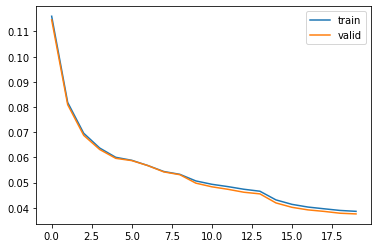

In [82]:
plt.plot(err_train, label='train')
plt.plot(err_valid, label='valid')
plt.legend()

In [80]:
with torch.no_grad():
    pred = torch.sigmoid(model(train_dataset[:][0]))
    acc = torch.mean( ((pred>0.5) == train_dataset[:][1].to(torch.int32)  ) * 1.0 )
print("Accuracy on train:", acc)

Accuracy on train: tensor(0.9922)


In [81]:
with torch.no_grad():
    pred = torch.sigmoid(model(validation_dataset[:][0]))
    acc = torch.mean( ((pred>0.5) == validation_dataset[:][1].to(torch.int32)  ) * 1.0 )
print("Accuracy on valid:", acc)

Accuracy on valid: tensor(0.9925)
